# 实验八：中国股市尾部风险测度的估计与检验

In [1]:
import numpy as np         
import pandas as pd         
import requests            
from scipy.stats import norm, chi2, genpareto  # 统计分布函数
import matplotlib.pyplot as plt               
from arch import arch_model  

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False  

In [2]:
# 从新浪财经API获取上证指数数据
res = requests.get('http://money.finance.sina.com.cn/quotes_service/api/json_v2.php/CN_MarketData.getKLineData?symbol=sh000001&scale=240&ma=no&datalen=10000')
# scale单位是分钟（设置数据的时间周期为240分钟）。这个地址数据很全，开盘、收盘、最高、最低、成交量。
# ma 移动平均参数（ma=no：不计算移动平均线）
# datalen 数据量参数（获取最多10000条数据）
data_json = res.json()
data = pd.DataFrame(data_json)
data.to_csv('data_ssec.csv')
print(data)

             day      open      high       low     close       volume
0     1990-12-19    96.050    99.980    95.790    99.980       126000
1     1990-12-20   104.300   104.390    99.980   104.390        19700
2     1990-12-21   109.070   109.130   103.730   109.130         2800
3     1990-12-24   113.570   114.550   109.130   114.550         3200
4     1990-12-25   120.090   120.250   114.550   120.250         1500
...          ...       ...       ...       ...       ...          ...
8377  2025-04-14  3251.978  3272.720  3244.733  3262.808  47137322000
8378  2025-04-15  3260.685  3268.985  3246.337  3267.662  39666289500
8379  2025-04-16  3267.665  3276.005  3233.791  3276.004  42953485400
8380  2025-04-17  3261.718  3285.915  3258.145  3280.341  38201269800
8381  2025-04-18  3270.353  3283.090  3262.392  3276.730  35883619300

[8382 rows x 6 columns]


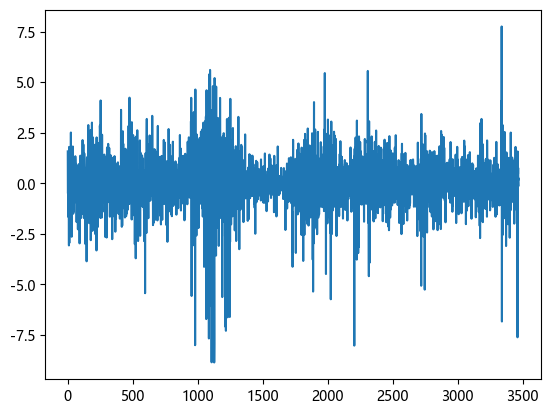

In [3]:
# 读取保存的CSV文件
data = pd.read_csv('data_ssec.csv')
# 计算对数收益率
data['return'] = np.log(data['close']) - np.log(data['close'].shift(periods=1))
# 将日期列转换为日期时间格式
data['day'] = pd.to_datetime(data['day'], format='%Y-%m-%d')
# 提取2011年1月1日之后的数据（共3500天左右）
ind = data['day'] >= pd.to_datetime('2011-01-01', format='%Y-%m-%d')
r = data[ind]['return'].values*100  # 将收益率转换为百分比
# 绘制收益率时间序列图
plt.plot(r)
plt.show()

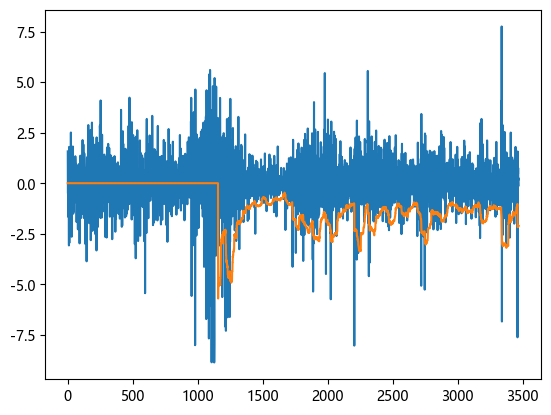

In [4]:
# RiskMetrics方法
l = np.fix(len(r)/3).astype(int)  # 样本量的1/3作为训练集长度
VaR_RM = np.zeros(len(r))         # 初始化VaR数组
qalpha = norm.ppf(0.05)           # 计算标准正态分布的5%分位点

for i in range(l, len(r)):
    # 这个窗口大小为50是一个经验性选择，通常认为约两个月的交易数据（大约40-50个交易日）足以捕捉近期市场波动特征，同时又不会过于敏感于短期波动。
    mhat, shat = norm.fit(r[i-50:i])  # 使用最近50个交易日的数据拟合正态分布
    VaR_RM[i] = -(mhat + qalpha*shat) # 计算VaR

# 绘制原始收益率和VaR对比图
plt.plot(r)
plt.plot(VaR_RM*-1)
"""
plt.plot(VaR_RM*-1)中的*-1做了如下事情：

将计算得到的正VaR值转换回负值
使VaR线显示在图表的下半部分（负值区域）
让VaR线与收益率数据直观对应，显示为下行风险的边界
"""
plt.show()

风险价值(VaR)的RiskMetrics方法

这段代码实现了RiskMetrics方法来计算风险价值（Value at Risk, VaR）：
1. 将样本分为训练集和测试集，训练集约为样本总量的三分之一
2. 计算标准正态分布的5%分位点，即$\Phi^{-1}(0.05) \approx -1.645$
3. 对于测试集中的每一天：
   - 使用前50个交易日的数据拟合正态分布，得到均值mhat和标准差shat
   - 计算95%置信度的VaR：$VaR_{0.05} = -(μ + \Phi^{-1}(0.05) \cdot \sigma)$
4. 绘制原始收益率和VaR的对比图

RiskMetrics方法假设收益率服从正态分布，是金融风险管理中的经典方法。

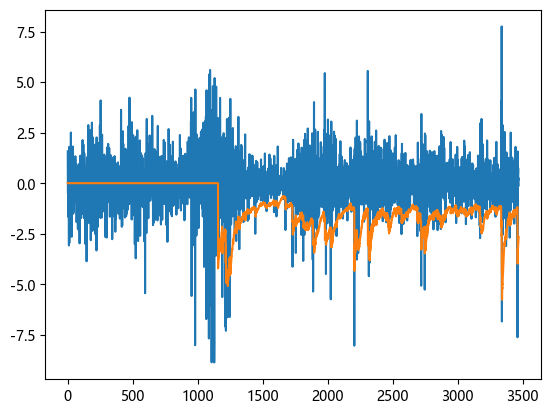

In [5]:
l = np.fix(len(r)/3).astype(int)  # 样本量的1/3作为训练集长度
VaR_GN = np.zeros(len(r))         # 初始化VaR数组
qalpha = norm.ppf(0.05)           # 计算标准正态分布的5%分位点

for i in range(l, len(r)):
    # 构建历史数据带有AR(1)均值方程和GARCH(2,2)波动率方程的模型
    am_ar_garch = arch_model(r[:i], mean='ar', lags=1, vol='garch', dist='normal', p=2, q=2)
    # 拟合模型，disp off 关闭中间输出，只保留结果
    res_ar_garch = am_ar_garch.fit(disp='off')
    # 预测下一期的条件均值和条件方差
    a = res_ar_garch.forecast(horizon=1, align='origin')
    mu = a.mean['h.1'].iloc[-1]          # 提取条件均值预测
    sigma = a.variance['h.1'].iloc[-1]   # 提取条件方差预测
    # 计算VaR
    VaR_GN[i] = -(mu + qalpha * np.sqrt(sigma))
    
# 绘制原始收益率和VaR对比图
plt.plot(r)
plt.plot(VaR_GN*-1)
plt.show()

GARCH-Normal模型的VaR估计

这段代码使用AR(1)-GARCH(2,2)模型估计VaR：
1. 模型设定：
   - 均值方程为AR(1)：$r_t = c + \phi_1 r_{t-1} + \varepsilon_t$
   - 波动率方程为GARCH(2,2)：$\sigma_t^2 = \omega + \alpha_1 \varepsilon_{t-1}^2 + \alpha_2 \varepsilon_{t-2}^2 + \beta_1 \sigma_{t-1}^2 + \beta_2 \sigma_{t-2}^2$
   - 残差分布假设为正态分布
2. 对于测试集中的每一天：
   - 用历史数据拟合模型
   - 预测下一天的条件均值和条件波动率
   - 计算95%置信度的VaR：$VaR_{0.05} = -(μ_{t+1|t} + \Phi^{-1}(0.05) \cdot \sqrt{\sigma_{t+1|t}^2})$
3. 绘制收益率与VaR的对比图

GARCH模型能够捕捉金融收益率中的波动率聚集效应，相比RiskMetrics方法更加灵活。

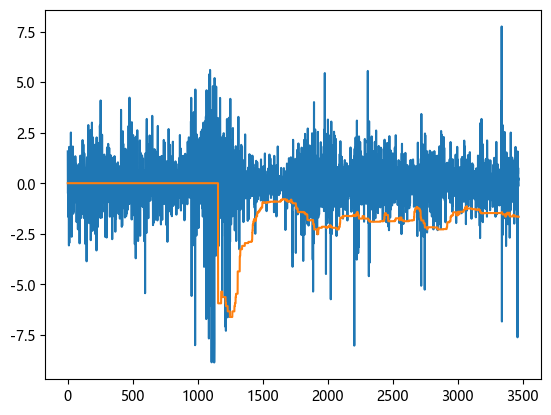

In [6]:
# 历史模拟方法
l = np.fix(len(r)/3).astype(int)  # 样本量的1/3作为训练集长度
VaR_HS = np.zeros(len(r))         # 初始化VaR数组
qalpha = int(200*0.05)            # 计算200个样本的5%分位数索引

for i in range(l, len(r)):
    his_sample = r[i-200:i]       # 取前200个交易日的收益率
    his_sample = np.sort(his_sample)  # 对历史样本排序
    VaR_HS[i] = -his_sample[qalpha-1]  # 选择对应百分位的值作为VaR

# 绘制原始收益率和VaR对比图
plt.plot(r)
plt.plot(VaR_HS*-1)
plt.show()

历史模拟法(Historical Simulation)

这段代码实现了历史模拟法（Historical Simulation）：
1. 对于测试集中的每一天：
   - 提取前200个交易日的历史收益率
   - 对这些收益率进行排序
   - 选择第5%分位点（即第10个最小值，因为200×0.05=10）作为VaR
2. 绘制收益率与VaR的对比图

历史模拟法是一种非参数方法，不依赖于任何分布假设，直接使用历史数据的经验分布来估计风险。它的优点是简单直观，缺点是在极端情况下可能不够准确。


evt_sample: [8.87317541 8.86494311 8.01754231 7.93754391 7.68453531 6.72599554
 6.63026201 6.34439868 6.08214417 5.94547313 5.36736891 4.36617693
 4.14125653 3.74363917 3.58294983 3.5385248  3.52907982 3.52330326
 3.48147356 3.39214296]

u: 3.3921429610442644

evt_sample - u : [5.48103245 5.47280015 4.62539935 4.54540095 4.29239235 3.33385258
 3.23811905 2.95225572 2.69000121 2.55333017 1.97522595 0.97403397
 0.74911357 0.35149621 0.19080687 0.14638183 0.13693686 0.1311603
 0.0893306  0.        ]

evt_final : [5.48103245 5.47280015 4.62539935 4.54540095 4.29239235 3.33385258
 3.23811905 2.95225572 2.69000121 2.55333017 1.97522595 0.97403397
 0.74911357 0.35149621 0.19080687 0.14638183 0.13693686 0.1311603
 0.0893306 ]



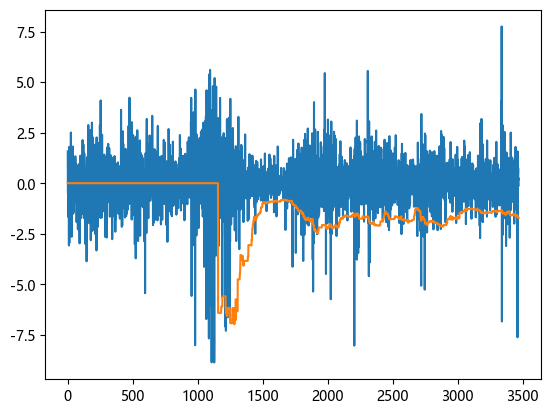

In [7]:
# POT方法
l = np.fix(len(r)/3).astype(int)  # 样本量的1/3作为训练集长度
VaR_EVT = np.zeros(len(r))        # 初始化VaR数组
alpha = 0.05                       # 设置风险水平为5%

for i in range(l, len(r)):
    his_sample = r[i-200:i]        # 取前200个交易日的收益率
    his_sample = np.sort(his_sample)  # 对历史样本排序
    ind = np.ceil(len(his_sample)*0.1).astype(int)  # 取最小的10%作为极端值，np.ceil() 向上取整，确保至少有指定比例的样本
    evt_sample = np.abs(his_sample[:ind])  # 取绝对值(负收益率)
    if i == l: 
        print(f'evt_sample: {evt_sample}\n')
    u = evt_sample[-1]             # 设定阈值为最大的极端值
    if i == l: 
        print(f'u: {u}\n')

    evt_sample = evt_sample - u    # 计算超额部分
    if i == l: 
        print(f'evt_sample - u : {evt_sample}\n')
    evt_sample = np.delete(evt_sample, -1)  # 删除阈值点
    if i == l: 
        print(f'evt_final : {evt_sample}\n')

    n = len(his_sample)            # 样本总数
    Nu = len(evt_sample)           # 超过阈值的样本数

    # 使用广义帕累托分布(GPD)拟合超额部分
    parmhat = genpareto.fit(evt_sample, floc=0)
    kHat = parmhat[0]    # 尾部指数参数
    sigmaHat = parmhat[2]  # 尺度参数
    
    # 使用POT方法计算VaR
    VaR_EVT[i] = u + sigmaHat / kHat * ((alpha * n / Nu) ** -kHat - 1)

# 绘制原始收益率和VaR对比图
plt.plot(r)
plt.plot(VaR_EVT*-1)
plt.show()

峰值超额法(POT, Peaks Over Threshold)

这段代码实现了极值理论中的峰值超额法(POT)：
1. 对于测试集中的每一天：
   - 提取前200个交易日的历史收益率
   - 对收益率排序，选取最小的10%作为极端值样本
   - 设定阈值u为这些极端值中的最大值
   - 计算超过阈值的超额部分
   - 使用广义帕累托分布(GPD)拟合这些超额值
   - 根据极值理论公式计算VaR：
     $VaR_{α} = u + \frac{σ}{k}[((\frac{α·n}{N_u})^{-k} - 1)]$
     其中，k是形状参数，σ是尺度参数，n是总样本数，Nu是超过阈值的样本数
2. 绘制收益率与VaR的对比图

POT方法基于极值理论，专门用于建模极端事件的发生概率，特别适合分析金融市场的尾部风险。

In [8]:
# 将所有VaR结果与收益率保存到CSV文件
data = pd.DataFrame({'return': r, 'VaR_RM': VaR_RM, 'VaR_GN': VaR_GN, 'VaR_HS': VaR_HS, 'VaR_EVT': VaR_EVT})
data.to_csv('Data_VaR.csv')

In [9]:
# Kupiec覆盖率测试函数
def myfun_Kupiec(r, VaR, pstar):
    N = np.sum(r > VaR)  # 超过VaR的次数
    T = len(r)           # 总样本数
    # 计算似然比统计量
    LRuc = -2*((T-N)*np.log(1-pstar)+N*np.log(pstar)) + 2*((T-N)*np.log(1-N/T)+N*np.log(N/T))
    # 计算p值（卡方分布自由度为1）
    pvalue_LRuc = 1 - chi2.cdf(LRuc, 1)
    return LRuc, pvalue_LRuc

# Christoffersen独立性测试函数
def myfun_Christoffersen(r, VaR):
    ind = r > VaR  # 超过VaR的指示变量
    ind1 = ind[:-1]  # 当前期指示变量
    ind2 = ind[1:]   # 下一期指示变量
    # 计算转移矩阵中的频数
    n00 = np.sum((ind1==0) & (ind2==0))  # 连续两期都未超过VaR的次数
    n01 = np.sum((ind1==0) & (ind2==1))  # 从未超过到超过的次数
    n10 = np.sum((ind1==1) & (ind2==0))  # 从超过到未超过的次数
    n11 = np.sum((ind1==1) & (ind2==1))  # 连续两期都超过VaR的次数

    # 计算条件概率
    Pi01 = n01/(n01+n00)  # 前一期未超过VaR，当期超过VaR的条件概率
    Pi11 = n11/(n10+n11)  # 前一期超过VaR，当期超过VaR的条件概率
    Pi2 = (n01+n11)/(n00+n01+n10+n11)  # 无条件超过VaR概率

    # 计算似然比统计量
    LRind = (n00+n10)*np.log(1-Pi2) + (n01+n11)*np.log(Pi2) - \
            n00*np.log(1-Pi01) - n01*np.log(Pi01) - n10*np.log(1-Pi11) - n11*np.log(Pi11)
    LRind = LRind*-2
    # 计算p值（卡方分布自由度为1）
    pvalue_LRind = 1 - chi2.cdf(LRind, 1)
    return LRind, pvalue_LRind

# 组合测试函数
def myfun_Kupiec_Christoffersen(LRuc, LRind):
    LRcc = LRuc + LRind  # 联合统计量是两个统计量之和
    # 计算p值（卡方分布自由度为2）
    pvalue_LRcc = 1 - chi2.cdf(LRcc, 2)
    return LRcc, pvalue_LRcc

## 1. Kupiec覆盖率测试

### 原理解释

Kupiec测试（又称无条件覆盖率测试）检验实际超过VaR的频率是否与理论预期频率相符。

假设我们计算了95%置信度的VaR，理论上损失超过VaR的概率应该是5%。但在实际回测中，如果观察到的超越比例明显不等于5%，则说明VaR模型可能有问题：
- 超越比例显著高于5%：模型低估了风险（危险）
- 超越比例显著低于5%：模型过度保守（浪费资本）

### 数学推导

该测试基于似然比原理。首先建立原假设H₀和备择假设H₁：
- H₀：真实超越概率 = 预设水平α（例如5%）
- H₁：真实超越概率 ≠ 预设水平α

在H₀下，观测到N次超越的对数似然函数为：
$$L(α) = (T-N)\ln(1-α) + N\ln(α)$$

在H₁下，最大似然估计得到的超越概率为 $\hat{p} = N/T$，对应的对数似然函数为：
$$L(\hat{p}) = (T-N)\ln(1-\hat{p}) + N\ln(\hat{p})$$

似然比统计量为：
$$LR_{uc} = -2[L(α) - L(\hat{p})]$$

在H₀成立时，LR_{uc}近似服从自由度为1的卡方分布。

### 测试解读

实际应用中，我们计算p值并与显著性水平（通常为5%）比较：
- 如果p值 < 0.05：拒绝H₀，表明VaR模型的覆盖率有问题
- 如果p值 ≥ 0.05：无法拒绝H₀，表明VaR模型的覆盖率合理

## 2. Christoffersen独立性测试

### 原理解释

Christoffersen独立性测试检验VaR超越事件是否相互独立。在有效的风险管理模型中，今天超过VaR的概率不应该受到昨天是否超过VaR的影响。

如果VaR超越事件表现出聚类性（例如，一旦发生超越，第二天也更可能发生超越），这表明模型没有充分捕捉到风险的动态特性，尤其是波动率聚集效应。

### 数学模型：一阶马尔可夫链

该测试使用一阶马尔可夫链建模超越事件的时间依赖性。定义转移概率：
- π₀₁ = P(今天超越|昨天未超越)
- π₁₁ = P(今天超越|昨天超越)

在独立性假设下，这两个概率应该相等，即π₀₁ = π₁₁。

测试的假设为：
- H₀：π₀₁ = π₁₁（超越事件相互独立）
- H₁：π₀₁ ≠ π₁₁（超越事件存在时间依赖性）

### 转移矩阵和似然函数

代码中计算了转移矩阵的四个元素：
- n₀₀：连续两天都未超越的次数
- n₀₁：从未超越到超越的次数
- n₁₀：从超越到未超越的次数 
- n₁₁：连续两天都超越的次数

在H₀下，最大似然估计得到的共同超越概率是π₂ = (n₀₁ + n₁₁)/(n₀₀ + n₀₁ + n₁₀ + n₁₁)。
在H₁下，最大似然估计得到的条件概率是π₀₁ = n₀₁/(n₀₀ + n₀₁)和π₁₁ = n₁₁/(n₁₀ + n₁₁)。

似然比统计量LR_{ind}比较这两个模型的对数似然函数，在H₀成立时近似服从自由度为1的卡方分布。

### 测试解读

- 如果p值 < 0.05：拒绝H₀，表明VaR超越事件存在聚类性
- 如果p值 ≥ 0.05：无法拒绝H₀，表明VaR超越事件大致独立

## 3. 条件覆盖率测试

### 原理解释

条件覆盖率测试是前两个测试的综合，同时检验覆盖率和独立性。一个好的VaR模型应该既能准确预测超越的频率，又能确保超越事件之间相互独立。

这个测试特别重要，因为单独通过覆盖率测试的模型可能会因为超越事件的聚类性而被拒绝，单独通过独立性测试的模型也可能因为总体覆盖率不准确而被拒绝。

### 数学性质

条件覆盖率统计量简单地将前两个测试的统计量相加：
$$LR_{cc} = LR_{uc} + LR_{ind}$$

在原假设（覆盖率正确且超越事件独立）成立时，LR_{cc}近似服从自由度为2的卡方分布。

### 测试解读

- 如果p值 < 0.05：拒绝联合原假设，模型存在覆盖率问题或/和独立性问题
- 如果p值 ≥ 0.05：无法拒绝联合原假设，模型既有合理的覆盖率又满足独立性要求

## 实际应用示例

假设我们有1000天的数据，VaR模型预测出每天的风险值，实际观察到45次超越：

1. **Kupiec测试**：
   - 预期超越率是5%，实际是4.5%
   - 计算LRuc = 0.42，p值 = 0.52 > 0.05
   - 结论：覆盖率合理

2. **Christoffersen测试**：
   - 发现在45次超越中，有12次是连续发生的
   - 计算LRind = 8.32，p值 = 0.004 < 0.05
   - 结论：超越事件存在聚类性，不满足独立性

3. **条件覆盖率测试**：
   - LRcc = 0.42 + 8.32 = 8.74，p值 = 0.013 < 0.05
   - 结论：尽管覆盖率合理，但由于独立性问题，模型整体被拒绝

In [10]:
# 读取保存的VaR数据
data = pd.read_csv('Data_VaR.csv')
data

,Unnamed: 0,return,VaR_RM,VaR_GN,VaR_HS,VaR_EVT
0,0,1.574778,0.000000,0.000000,0.000000,0.000000
1,1,-0.493918,0.000000,0.000000,0.000000,0.000000
2,2,-0.508443,0.000000,0.000000,0.000000,0.000000
3,3,0.515770,0.000000,0.000000,0.000000,0.000000
4,4,-1.669201,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
3466,3466,0.756222,2.135205,3.070074,1.661618,1.711993
3467,3467,0.148657,2.134116,2.967560,1.661618,1.711993
3468,3468,0.254964,2.139442,2.862242,1.661618,1.711993
3469,3469,0.132299,2.133767,2.758842,1.661618,1.711993


In [11]:
# 仅保留有效的VaR估计结果
"""
在进行VaR回测时，我们需要比较实际损失与VaR预测值。如果VaR为0或负值，这种比较就没有实际意义，因为：

VaR = 0 意味着没有预测风险，这不可能是准确的
VaR < 0 在理论上意味着预期收益而非损失，这与VaR作为风险测度的本质不符
"""
ind = data['VaR_RM'] > 0

# 原return中，正表示收益，负表示亏损。而风险管理中，损失用正数表示，收益用负数表示
r = data.loc[ind, ['return']].values*-1
VaR_RM = data.loc[ind, ['VaR_RM']].values
VaR_GN = data.loc[ind, ['VaR_GN']].values
VaR_HS = data.loc[ind, ['VaR_HS']].values
VaR_EVT = data.loc[ind, ['VaR_EVT']].values

r

array([[ 0.93931579],
       [-2.29180062],
       [-1.58349676],
       ...,
       [-0.25496425],
       [-0.13229934],
       [ 0.11014065]])

In [12]:
pstar = 0.05  # 设置显著性水平为5%

# RiskMetrics方法回测
[LRuc_RM, pvalue_LRuc_RM] = myfun_Kupiec(r, VaR_RM, pstar)
[LRind_RM, pvalue_LRind_RM] = myfun_Christoffersen(r, VaR_RM)
[LRcc_RM, pvalue_LRcc_RM] = myfun_Kupiec_Christoffersen(LRuc_RM, LRind_RM)

# GARCH-Normal方法回测
[LRuc_GN, pvalue_LRuc_GN] = myfun_Kupiec(r, VaR_GN, pstar)
[LRind_GN, pvalue_LRind_GN] = myfun_Christoffersen(r, VaR_GN)
[LRcc_GN, pvalue_LRcc_GN] = myfun_Kupiec_Christoffersen(LRuc_GN, LRind_GN)

# 历史模拟法回测
[LRuc_HS, pvalue_LRuc_HS] = myfun_Kupiec(r, VaR_HS, pstar)
[LRind_HS, pvalue_LRind_HS] = myfun_Christoffersen(r, VaR_HS)
[LRcc_HS, pvalue_LRcc_HS] = myfun_Kupiec_Christoffersen(LRuc_HS, LRind_HS)

# 峰值超额法回测
[LRuc_EVT, pvalue_LRuc_EVT] = myfun_Kupiec(r, VaR_EVT, pstar)
[LRind_EVT, pvalue_LRind_EVT] = myfun_Christoffersen(r, VaR_EVT)
[LRcc_EVT, pvalue_LRcc_EVT] = myfun_Kupiec_Christoffersen(LRuc_EVT, LRind_EVT)

In [13]:
# 打印回测结果
print('{:12s}, {:>12s}, {:>12s}, {:>12s}, {:>12s}, {:>12s}, {:>12s}'.format('', 'LRuc', 'pLRuc', 'LRind', 'pLRind', 'LRcc', 'pLRcc'))
print('{:12s}, {:12.4f}, {:12.4f}, {:12.4f}, {:12.4f}, {:12.4f}, {:12.4f}'.format('RiskMetrics', LRuc_RM, pvalue_LRuc_RM, LRind_RM, pvalue_LRind_RM, LRcc_RM, pvalue_LRcc_RM))
print('{:12s}, {:12.4f}, {:12.4f}, {:12.4f}, {:12.4f}, {:12.4f}, {:12.4f}'.format('GarchNormal', LRuc_GN, pvalue_LRuc_GN, LRind_GN, pvalue_LRind_GN, LRcc_GN, pvalue_LRcc_GN))
print('{:12s}, {:12.4f}, {:12.4f}, {:12.4f}, {:12.4f}, {:12.4f}, {:12.4f}'.format('HisSim', LRuc_HS, pvalue_LRuc_HS, LRind_HS, pvalue_LRind_HS, LRcc_HS, pvalue_LRcc_HS))
print('{:12s}, {:12.4f}, {:12.4f}, {:12.4f}, {:12.4f}, {:12.4f}, {:12.4f}'.format('EVT GPD', LRuc_EVT, pvalue_LRuc_EVT, LRind_EVT, pvalue_LRind_EVT,LRcc_EVT, pvalue_LRcc_EVT))

            ,         LRuc,        pLRuc,        LRind,       pLRind,         LRcc,        pLRcc
RiskMetrics ,       0.4755,       0.4905,       7.3928,       0.0065,       7.8683,       0.0196
GarchNormal ,       0.0668,       0.7960,       1.0948,       0.2954,       1.1616,       0.5595
HisSim      ,       0.2036,       0.6518,       7.0276,       0.0080,       7.2312,       0.0269
EVT GPD     ,       0.0668,       0.7960,      10.5063,       0.0012,      10.5731,       0.0051


## 1. RiskMetrics模型

| 统计量 | 值 | p值 | 结论 |
|--------|------|-------|------|
| LRuc | 0.4755 | 0.4905 | 通过覆盖率测试 |
| LRind | 7.3928 | 0.0065 | 不通过独立性测试 |
| LRcc | 7.8683 | 0.0196 | 不通过条件覆盖率测试 |

**解读**：
- 覆盖率测试p值(0.4905 > 0.05)表明模型预测的VaR超越频率与预期的5%没有显著差异
- 独立性测试p值(0.0065 < 0.05)表明VaR超越事件存在显著的时间聚集性
- 条件覆盖率测试p值(0.0196 < 0.05)表明综合考虑两个因素，该模型被拒绝

RiskMetrics模型虽然在频率上表现良好，但未能有效捕捉市场风险的时间依赖性，可能在市场波动加剧时表现不佳。

## 2. GARCH-Normal模型

| 统计量 | 值 | p值 | 结论 |
|--------|------|-------|------|
| LRuc | 0.0668 | 0.7960 | 通过覆盖率测试 |
| LRind | 1.0948 | 0.2954 | 通过独立性测试 |
| LRcc | 1.1616 | 0.5595 | 通过条件覆盖率测试 |

**解读**：
- 该模型是唯一一个通过所有三项测试的模型
- 覆盖率测试p值(0.7960)非常高，表明VaR预测的频率与理论预期极为接近
- 独立性测试p值(0.2954 > 0.05)表明VaR超越不存在明显的时间依赖性
- 条件覆盖率测试p值(0.5595 > 0.05)是所有模型中最高的

GARCH-Normal模型通过动态捕捉市场波动率的变化，同时考虑了波动率的持续性特征，在预测市场风险方面显著优于其他方法。

## 3. 历史模拟法(HisSim)

| 统计量 | 值 | p值 | 结论 |
|--------|------|-------|------|
| LRuc | 0.2036 | 0.6518 | 通过覆盖率测试 |
| LRind | 7.0276 | 0.0080 | 不通过独立性测试 |
| LRcc | 7.2312 | 0.0269 | 不通过条件覆盖率测试 |

**解读**：
- 覆盖率测试p值(0.6518 > 0.05)表明预测的VaR超越频率合理
- 独立性测试p值(0.0080 < 0.05)表明超越事件显著聚集
- 条件覆盖率测试p值(0.0269 < 0.05)导致模型整体被拒绝

历史模拟法虽然简单直观，但由于它对所有历史数据赋予相同权重，无法及时反映市场状况的变化，导致风险预测在时间上缺乏独立性。

## 4. 极值理论模型(EVT GPD)

| 统计量 | 值 | p值 | 结论 |
|--------|------|-------|------|
| LRuc | 0.0668 | 0.7960 | 通过覆盖率测试 |
| LRind | 10.5063 | 0.0012 | 强烈拒绝独立性假设 |
| LRcc | 10.5731 | 0.0051 | 不通过条件覆盖率测试 |

**解读**：
- 覆盖率测试p值(0.7960)与GARCH-Normal相同，表明频率预测准确
- 独立性测试p值(0.0012)是所有模型中最低的，表明超越事件高度聚集
- 条件覆盖率测试p值(0.0051)表明模型整体表现不佳

尽管EVT模型专门设计用于刻画极端风险，但它在处理风险的时间依赖性方面存在明显缺陷。

## 总体结论

1. **GARCH-Normal模型**明显优于其他模型，是唯一一个同时通过覆盖率和独立性测试的方法。这表明动态捕捉市场波动率变化对于准确预测风险至关重要。

2. 所有模型在**覆盖率**方面表现都不错，表明它们能够较准确地预测长期平均风险水平。

3. 除GARCH-Normal外，其他模型在**独立性测试**中表现不佳，说明它们无法充分捕捉市场风险的时间依赖特性。

4. **实际应用建议**：
   - 在风险管理实践中，应优先考虑GARCH类模型
   - 如需刻画极端风险，可以考虑结合GARCH与EVT的优势
   - 简单的历史模拟法和RiskMetrics方法虽然易于实施，但在市场波动较大时可能提供误导性的风险估计

这些结果进一步证实了条件异方差模型(如GARCH)在金融风险管理中的重要性，尤其是在处理具有波动率聚集特性的金融市场时。